# Description

Data generator notebook for PrototypicalNetworkTUF. The notebook generates two data sets

- A support data set
- A query data set

both contain the labels. The support data set has significantly less data points than the query data set. 
The two sets are stored as CSV files in the path specified by the ```SAVE_DATA_PATH``` variable. Similarly, the sets are stored respectively in the variables ```SAVE_SUPPORT_SET_FILENAME``` and ```SAVE_QUERY_SET_FILENAME```. The number of shots i.e the number of examples per class in the support set is given by the ```N_SHOTS``` variable. The rest of the examples for the class go in the  query set.

## Imports

In [33]:
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import mixture

In [34]:
sns.set(color_codes=True)

In [35]:
from utils import load_data_file
from utils import make_data_array
from utils import INFO

## Constants

In [36]:
# file paths and filenames
SAVE_DATA_PATH = "/home/alex/qi3/few_shot_learning_dna/data/train/proto/"
SAVE_SUPPORT_SET_FILENAME = "proto_support.csv"
SAVE_QUERY_SET_FILENAME = "proto_query.csv"

In [37]:
# number of examples per class to store in the 
# support set
N_SHOTS = 10

In [9]:
# various variables used in the GMM clustering model
NUM_CLUSTERS=5
COVARIANCE_TYPE = 'diag'
MAX_ITRS=1000
TOL=1.0e-5
N_INIT=1
TUF_NUM_CLUSTERS=3
COLORS = np.array(['green', 'blue', 'red',
                   'yellow', 'pink', 'orange', 
                   'purple', 'navy', 'brown'])

# add black color for outliers (if any)
COLORS = np.append(COLORS, ["#000000"])

### Load the data

In [10]:
# TUF region data
wga_mu_tuf_file = "data/train/raw/wga_windows_mean_0_TUF_I_CHR_1_MEAN_CUTOFF.txt"
nowga_mu_tuf_file = "data/train/raw/no_wga_windows_mean_0_TUF_I_CHR_1_MEAN_CUTOFF.txt"

# single copy deletion data
wga_mu_single_copy_del_file = "data/train/raw/wga_windows_mean_0_SINGLE_COPY_DELETION_CHR_2_MEAN_CUTOFF.txt"
nowga_mu_single_copy_del_file = "data/train/raw/no_wga_windows_mean_0_SINGLE_COPY_DELETION_CHR_2_MEAN_CUTOFF.txt"

# duplication data
wga_mu_duplication_file = "data/train/raw/wga_windows_mean_0_DUPLICATION_CHR_1_MEAN_CUTOFF.txt"
nowga_mu_duplication_file = "data/train/raw/no_wga_windows_mean_0_DUPLICATION_CHR_1_MEAN_CUTOFF.txt"

# full copy deletion data
wga_mu_del_file = "data/train/raw/wga_windows_mean_0_DELETE_CHR_1_MEAN_CUTOFF.txt"
nowga_mu_del_file = "data/train/raw/no_wga_windows_mean_0_DELETE_CHR_1_MEAN_CUTOFF.txt"

In [11]:
wga_mu_tuf = load_data_file(filename=wga_mu_tuf_file, type_convert="FLOAT")
nowga_mu_tuf = load_data_file(filename=nowga_mu_tuf_file, type_convert="FLOAT")

assert len(wga_mu_tuf) == len(nowga_mu_tuf), "Invalid data size for TUF data"

wga_mu_single_copy_del = load_data_file(filename=wga_mu_single_copy_del_file, 
                                             type_convert="FLOAT")
nowga_mu_single_copy_del = load_data_file(filename=nowga_mu_single_copy_del_file, 
                                                type_convert="FLOAT")

assert len(wga_mu_single_copy_del) == len(nowga_mu_single_copy_del), \
"Invalid data size for single copy deletion data"

wga_mu_duplication = load_data_file(filename=wga_mu_duplication_file, type_convert="FLOAT")
nowga_mu_duplication = load_data_file(filename=nowga_mu_duplication_file, type_convert="FLOAT")

assert len(wga_mu_duplication) == len(nowga_mu_duplication), "Invalid data size for duplication data"

wga_mu_del = load_data_file(filename=wga_mu_del_file, type_convert="FLOAT")
nowga_mu_del = load_data_file(filename=nowga_mu_del_file, type_convert="FLOAT")

assert len(wga_mu_del) == len(nowga_mu_del), "Invalid data size for full deletion data"

### Mix the data

In [12]:

# WGA sample
wga_mu = []
wga_mu.extend(wga_mu_single_copy_del)
wga_mu.extend(wga_mu_duplication)
wga_mu.extend(wga_mu_del)


# NO-WGA sample
no_wga_mu = []
no_wga_mu.extend(nowga_mu_single_copy_del)
no_wga_mu.extend(nowga_mu_duplication)
no_wga_mu.extend(nowga_mu_del)

### Cluster the reference data

### GMM clustering

In [13]:
# Dictionay that holds the states for the HMM 
#states={}

In [14]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=False, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 2)

In [15]:
# the GMM cluster
gmm = mixture.GaussianMixture(n_components=NUM_CLUSTERS,
                              covariance_type=COVARIANCE_TYPE,
                              tol=TOL, max_iter=MAX_ITRS, n_init=N_INIT)

# fit the data
gmm.fit(data)
   

GaussianMixture(covariance_type='diag', max_iter=1000, n_components=5,
                tol=1e-05)

In [16]:
print("{0} GMM converged? {1}".format(INFO, gmm.converged_))
print("{0} GMM BIC metric {1}".format(INFO, gmm.bic(data)))    

INFO:  GMM converged? True
INFO:  GMM BIC metric 162882.30076878183


In [17]:
labels = gmm.predict(data)
print("{0} Number of labels= {1}".format(INFO, len(labels)))

INFO:  Number of labels= 11915


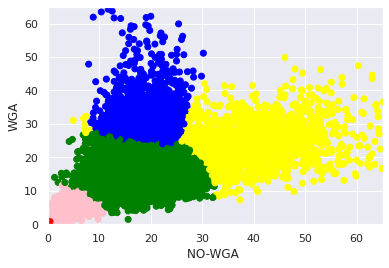

In [18]:
xlim=(0., 65.0)
ylim=(0., 65.0)

colors = COLORS[labels]

plt.scatter(no_wga_mu, wga_mu, color=colors)
plt.xlabel("NO-WGA ")
plt.ylabel("WGA")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()


In [19]:
# map that holds the association between the
# component color and component index

color_comp_assoc = {}
for label, color in zip(labels, colors):
    if color in color_comp_assoc.keys():
        assert color_comp_assoc[color][0] == label
        color_comp_assoc[color][1] += 1
    else:
        color_comp_assoc[color] = [label, 1]
        
print("{0} Color-Component association: {1}".format(INFO, color_comp_assoc))

INFO:  Color-Component association: {'green': [0, 7604], 'yellow': [3, 1551], 'blue': [1, 1897], 'pink': [4, 485], 'red': [2, 378]}


In [20]:
means = gmm.means_

for i in range(len(means)):
    print("{0} Component {1} mu's {2} ".format(INFO, i , means[i]))

INFO:  Component 0 mu's [17.91839586 15.70068199] 
INFO:  Component 1 mu's [19.29475984 27.15922904] 
INFO:  Component 2 mu's [0.0764719  0.13421094] 
INFO:  Component 3 mu's [36.26686975 24.47550828] 
INFO:  Component 4 mu's [4.73769001 4.54320524] 


In [21]:
csv_data = {"Duplicate": 3, 'Full-Delete': 2, 'Normal-1': 0, "Normal-2": 1, "Single-Delete": 4 }

### Cluster for TUF

In [22]:
tuf_wga_mu = []
tuf_wga_mu.extend(wga_mu_tuf)

tuf_nowga_mu = []
tuf_nowga_mu.extend(nowga_mu_tuf)

In [23]:
tuf_data = make_data_array(wga_mu=tuf_wga_mu, 
                           no_wga_mu=tuf_nowga_mu, gc=None, 
                           use_ratio=True, use_gc=False)

tuf_data = np.array(tuf_data)

assert tuf_data.shape == (len(tuf_wga_mu), 3)

In [24]:
# the GMM cluster
tuf_gmm = mixture.GaussianMixture(n_components=TUF_NUM_CLUSTERS,
                                  covariance_type=COVARIANCE_TYPE,
                                  tol=TOL, 
                                  max_iter=MAX_ITRS, n_init=N_INIT)

# fit the data
tuf_gmm.fit(tuf_data)

GaussianMixture(covariance_type='diag', max_iter=1000, n_components=3,
                tol=1e-05)

In [25]:
print("{0} GMM converged? {1}".format(INFO, tuf_gmm.converged_))
print("{0} GMM BIC metric {1}".format(INFO, tuf_gmm.bic(tuf_data)))  

INFO:  GMM converged? True
INFO:  GMM BIC metric 16196.753045051328


In [26]:
tuf_labels = tuf_gmm.predict(tuf_data)
print("{0} Number of labels= {1}".format(INFO, len(tuf_labels)))

INFO:  Number of labels= 1260


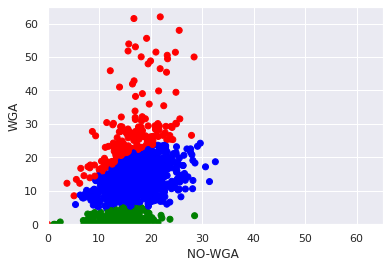

In [27]:
xlim=(0., 65.0)
ylim=(0., 65.0)

colors = COLORS[tuf_labels]

plt.scatter(tuf_nowga_mu, tuf_wga_mu, color=colors)
plt.xlabel("NO-WGA ")
plt.ylabel("WGA")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()


In [28]:
# map that holds the association between the
# component color and component index

tuf_color_comp_assoc = {}
for label, color in zip(tuf_labels, colors):
    if color in tuf_color_comp_assoc.keys():
        assert tuf_color_comp_assoc[color][0] == label
        tuf_color_comp_assoc[color][1] += 1
    else:
        tuf_color_comp_assoc[color] = [label, 1]

print("{0} TUF Color-cluster association={1}".format(INFO, tuf_color_comp_assoc))

INFO:  TUF Color-cluster association={'red': [2, 193], 'blue': [1, 882], 'green': [0, 185]}


In [29]:
csv_data_tuf = {'TUF': 0}

### Save the data

In [39]:
with open(SAVE_DATA_PATH + SAVE_SUPPORT_SET_FILENAME, 'w', newline='\n') as csvfile_support_set:
    
    # the writer of the support set
    csv_writer_support = csv.writer(csvfile_support_set, delimiter=',')
    
    # write an informative header
    csv_writer_support.writerow(['#', 
                                 'C:'+str(len(csv_data) + len(csv_data_tuf)),
                                 'K:'+str(N_SHOTS)])
    
    with open(SAVE_DATA_PATH + SAVE_QUERY_SET_FILENAME, 'w', newline='\n') as csvfile_query_set:
        
        # the writer of the support set
        csv_writer_query = csv.writer(csvfile_query_set, delimiter=',')
        
        # write an informative header
        csv_writer_query.writerow(['#', 
                                     'C:'+str(len(csv_data) + len(csv_data_tuf)),
                                     'K:'+str(N_SHOTS)])
    
    
    
        # write the data for rest of classes
        for item in csv_data:
            name = item
            label = csv_data[item]

            class_items = 0
            for idx in range(len(labels)):
                if labels[idx] == label:

                    # form the row to write
                    row = [data[idx][0], data[idx][1] , name]
                    
                    if class_items < N_SHOTS:
                        csv_writer_support.writerow(row)
                        class_items += 1
                    else:
                         csv_writer_query.writerow(row)

        # write the data for TUF
        for item in csv_data_tuf:
            name = item
            label= csv_data_tuf[item]

            class_items = 0
            for idx in range(len(tuf_labels)):
                if tuf_labels[idx] == label:
                    
                    row = [tuf_data[idx][0], tuf_data[idx][1] , name]
                    
                    if class_items < N_SHOTS:
                        csv_writer_support.writerow(row)
                        class_items += 1
                    else:
                        csv_writer_query.writerow(row)
                        
                    
    
    